# Weather Prediction

In this project, we want to see if we can use machine learning to predict daily weather conditions (high/low temperature and precipitation) for a location using data from surrounding locations from preceding days.

More specifically, we are going to train a machine-learning model using daily weather data obtained from [Automated Surface Observing System (ASOS)](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/automated-surface-observing-system-asos) units for the 20-year period from 1998 through 2017.  We will use the stations within a 1000-mile radius of Roswell, Georgia, USA (my home town) and try to make predictions for the observations of the closest ASOS unit to that location.

I'm not expecting this to provide very accurate forecasts, but it serves as a simple personal project that will let me exercise the knowledge gained through recent data-science and machine-learning courses.

In [1]:
import ftplib
import gzip
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from geopy import distance

/Users/kdj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sns.set_style('whitegrid')

%matplotlib inline

## Stations

Our first goal is to get the IDs of all the stations for which we will be processing data.  We want to get a list of all the stations that are within 1000 miles of our location.

In [3]:
# Roswell, GA, USA
my_lat = 34.0232
my_lon = -84.3616

distance_threshold = 1000

date_start = 19980101
date_end = 20171231

First, read the list of all stations available in the ASOS system.

(This data comes from <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv>, but I've stored the file locally.)

In [4]:
stations = pd.read_csv('isd/isd-history.csv',
                       dtype={'USAF'         : str,
                              'WBAN'         : str,
                              'STATION NAME' : str,
                              'CTRY'         : str,
                              'STATE'        : str,
                              'ICAO'         : str,
                              'LAT'          : np.float32,
                              'LON'          : np.float32,
                              'ELEV(M)'      : np.float32,
                              'BEGIN'        : int,
                              'END'          : int})

In [5]:
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007026,99999,WXPOD 7026,AF,NaN,NaN,0.0,0.0,7026.0,20140711,20170822
1,007070,99999,WXPOD 7070,AF,NaN,NaN,0.0,0.0,7070.0,20140923,20150926
2,008403,99999,XM10,NaN,NaN,NaN,NaN,NaN,NaN,20140101,20140412
3,008411,99999,XM20,NaN,NaN,NaN,NaN,NaN,NaN,20140102,20160217
4,008414,99999,XM18,NaN,NaN,NaN,NaN,NaN,NaN,20140101,20160217


In [6]:
stations.describe()

,LAT,LON,ELEV(M),BEGIN,END
count,28767.000000,28766.000000,28673.000000,3.005100e+04,3.005100e+04
mean,30.676743,-3.670850,339.499451,1.978650e+07,2.004861e+07
std,28.731548,87.375031,584.553223,2.365312e+05,1.899937e+05
min,-90.000000,-179.983002,-999.900024,1.901010e+07,1.905123e+07
25%,20.950001,-82.885252,20.000000,1.959010e+07,2.001101e+07
50%,38.909000,5.201000,133.000000,1.977070e+07,2.015072e+07
75%,49.658501,58.917000,424.899994,2.001113e+07,2.018042e+07
max,89.370003,179.750000,7070.000000,2.018040e+07,2.018042e+07


Let's drop any rows that have NaN for LAT or LON.

In [7]:
stations = stations.dropna(subset=['LAT', 'LON'])

Drop any stations for which USAF is 999999 and WBAN is 99999. (We'll be using USAF and WBAN as keys, so we want to ignore those that are not valid.)

In [8]:
stations = stations[(stations['USAF'] != '999999') & (stations['WBAN'] != '99999')]

We'll only look at the stations for the northern half of the western hemisphere.

In [9]:
stations = stations[(stations['LAT'] > 0.0) & (stations['LON'] < 0.0)]

Let's drop any stations for which data collection began after 1998-01-01 or ended before 2018-01-01.

In [10]:
stations = stations[stations['BEGIN'] <= date_start]
stations = stations[stations['END'] > date_end]

Now determine the distance between each station and my location.

In [11]:
def miles_from_my_location(station):
    my_loc = (my_lat, my_lon)
    station_loc = (station['LAT'], station['LON'])
    return distance.distance(my_loc, station_loc).miles

stations['DISTANCE'] = stations.apply(miles_from_my_location, axis=1)

And now only consider the stations within the 1000-mile radius.

In [12]:
stations = stations[stations['DISTANCE'] <= distance_threshold]

# Allow garbage collection of what we don't need from the original data frame.
stations = stations.copy()

Let's look at what we have.

In [13]:
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
14482,690190,13910,ABILENE DYESS AFB,US,TX,KDYS,32.432999,-99.849998,545.299988,19431201,20180420,902.861945
16389,716270,94792,MONTREAL/TRUDEAU INT,CA,QC,CYUL,45.466999,-73.733002,36.000000,19550101,20180419,969.588017
17932,722010,12836,KEY WEST INTERNATIONAL AIRPORT,US,FL,KEYW,24.555000,-81.751999,1.200000,19730101,20180420,670.793744
17940,722015,12850,KEY WEST NAS,US,FL,KNQX,24.583000,-81.682999,1.800000,19730101,20180420,669.904595
17947,722020,12839,MIAMI INTERNATIONAL AIRPORT,US,FL,KMIA,25.788000,-80.317001,8.800000,19730101,20180420,616.819963


In [14]:
stations.describe()

,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
count,352.000000,352.000000,352.000000,3.520000e+02,3.520000e+02,352.000000
mean,36.973999,-85.754684,184.507675,1.962627e+07,2.018042e+07,563.240059
std,5.125933,7.986055,171.884445,1.714906e+05,5.010734e+00,238.448254
min,24.555000,-101.704002,0.600000,1.935100e+07,2.018033e+07,11.541760
25%,32.612249,-92.412500,34.325001,1.944765e+07,2.018042e+07,371.302640
50%,37.776501,-85.191998,164.450005,1.973010e+07,2.018042e+07,570.701014
75%,41.246000,-79.626749,280.699997,1.973010e+07,2.018042e+07,759.788838
max,47.168999,-71.010002,1098.500000,1.997100e+07,2.018042e+07,990.405477


That gives us about 350 stations within the 1000-mile radius. If we plot the locations of these stations and our location, we can see a rough outline of the US East Coast and Gulf Coast, so our set of stations seems to be centered roughly around the southeastern US, as expected.

(-103.24604909142893,
 -69.46795542517262,
 23.412988414436633,
 48.31101060900086)

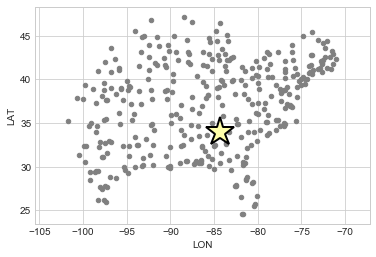

In [15]:
stations.plot.scatter(x='LON', y='LAT', c='gray')
plt.plot(my_lon, my_lat,
         '*', c='#ffffaa', markersize=30,
         markeredgewidth=2, markeredgecolor='black')
plt.axis('equal')

As a quick manual confidence check, let's look at the stations in Georgia.

In [17]:
stations[stations['STATE'] == 'GA']

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,DISTANCE
18030,722070,03822,SAVANNAH/HILTON HEAD INTL AIRPORT,US,GA,KSAV,32.131001,-81.202003,14.000000,19480101,20180420,224.941728
18132,722130,13861,WAYCROSS-WARE CO. AIRPORT,US,GA,KAYS,31.250000,-82.400002,43.299999,19421201,20180420,222.696213
18146,722137,13878,MALCOLM MC KINNON AIRPORT,US,GA,KSSI,31.152000,-81.390999,4.900000,19730101,20180420,262.984443
18186,722160,13869,SW GEORGIA REGIONAL ARPT,US,GA,KABY,31.535999,-84.194000,57.900002,19730101,20180420,171.671484
18196,722166,93845,VALDOSTA REGIONAL AIRPORT,US,GA,KVLD,30.783001,-83.277000,60.400002,19480101,20180420,232.092833
18204,722170,03813,MIDDLE GEORGIA REGIONAL AIRPORT,US,GA,KMCN,32.685001,-83.653000,104.599998,19411020,20180420,100.919384
18213,722175,13860,ROBINS AFB AIRPORT,US,GA,KWRB,32.632999,-83.599998,89.599998,19420807,20180420,105.452729
18223,722180,03820,AUGUSTA REGIONAL AT BUSH FIELD AP,US,GA,KAGS,33.363998,-81.962997,40.200001,19480101,20180420,145.457194
18241,722190,13874,HARTSFIELD-JACKSON ATLANTA INTL AP,US,GA,KATL,33.630001,-84.442001,307.899994,19730101,20180420,27.491862
18331,722250,13829,LAWSON AAF AIRPORT,US,GA,KLSF,32.349998,-85.000000,70.699997,19390501,20180420,121.096347


Those distance values look accurate (I checked using the ruler in Google Earth).

We can eyeball this list and see what the closest ASOS unit is, but we'll use Pandas to identify it.'

In [18]:
closest_station = stations.loc[stations['DISTANCE'].idxmin()]

In [19]:
closest_station

USAF                                      722270
WBAN                                       13864
STATION NAME    DOBBINS AIR RESERVE BASE AIRPORT
CTRY                                          US
STATE                                         GA
ICAO                                        KMGE
LAT                                       33.917
LON                                      -84.517
ELEV(M)                                    325.5
BEGIN                                   19460901
END                                     20180420
DISTANCE                                 11.5418
Name: 18352, dtype: object

So, we now have the 352 stations for which we will use data, and we will be trying to make predictions for the weather at [Dobbins ARB (KMGE)](https://en.wikipedia.org/wiki/Dobbins_Air_Reserve_Base).

## Fetching Weather Data for Stations

Next we need to obtain the weather information for each station for the 20-year period.

We will be using the "isd-lite" data, which is described in <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt> and <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-technical-document.txt>, and is available in subdirectories of <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/>.

We need some code to download these files as needed.

In [20]:
def data_file_name(station, year):
    """Return filename for the specified station for the specified year"""
    usaf = station['USAF']
    wban = station['WBAN']
    return f'{usaf}-{wban}-{year}.gz'

def ftp_server_data_path(station, year):
    """Return path to the file on the FTP server for the specified station for the specified year."""
    return f'/pub/data/noaa/isd-lite/{year}/{data_file_name(station, year)}'

def local_data_directory(year):
    """Return local directory for isd-lite data files for the specified year."""
    return f'isd/isd-lite/{year}'
    
def local_data_path(station, year):
    """Return path to local data file for the specified station for the specified year."""
    return f'{local_data_directory(year)}/{data_file_name(station, year)}'
    
def download_data_file(ftp, station, year):
    """Download the specified data file.
    
    Creates the destination directory if necessary.
    
    Returns the path to the downloaded file.
    """
    directory = local_data_directory(year)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    local_path = local_data_path(station, year)
    with open(local_path, 'wb') as f:
        cmd = f'RETR {ftp_server_data_path(station, year)}'
        ftp.retrbinary(cmd, f.write)
    return local_path

def get_downloaded_data_path(station, year, force_download=False):
    """Get path for the specified data file, downloading the file if necessary."""
    local_path = local_data_path(station, year)
    if force_download or not os.path.exists(local_path):
        ftp = ftplib.FTP('ftp.ncdc.noaa.gov')
        try:
            ftp.login()
            local_path = download_data_file(ftp, station, year)
        except Exception as e:
            # TODO: If the exception is not "File not found", need to
            # figure out what went wrong.
            print(f'Unable to download {local_path}: {e}')
        finally:
            ftp.quit()
    return local_path

def get_downloaded_station_data_paths(station, force_download=False):
    """Get paths for all data files for the specified station."""
    local_paths = [get_downloaded_data_path(station, year, force_download) for year in range(1998, 2019)]
    return local_paths

Each data file is a gzipped text file with the format described in <ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt>. We can use Pandas to read it into a data frame.

In [21]:
def read_station_data(path):
    """Read the isd-lite data from the specified path, returning a DataFrame.
    
    The data frame's columns are:
    
    - YEAR
    - MONTH
    - DAY
    - HOUR
    - TEMP (degrees Celsius)
    - DEWPOINT (degrees Celsius)
    - PRESSURE (hectopascals)
    - WIND_DIRECTION (degrees 0-360)
    - WIND_SPEED (meters per second)
    - COVERAGE (code)
    - PRECIP_1HR (millimeters)
    - PRECIP_6HR (millimeters)
    
    Values may be NaN, except for YEAR, MONTH, DAY, HOUR
    
    """
    df = pd.read_csv(path,
                     delim_whitespace=True,
                     header=None,
                     names=['YEAR', 'MONTH', 'DAY', 'HOUR',
                            'TEMP', 'DEWPOINT', 'PRESSURE',
                            'WIND_DIRECTION', 'WIND_SPEED',
                            'COVERAGE',
                            'PRECIP_1HR', 'PRECIP_6HR'],
                     dtype={'YEAR'           : int,
                            'MONTH'          : int,
                            'DAY'            : int,
                            'HOUR'           : int,
                            'TEMP'           : np.float32,
                            'DEWPOINT'       : np.float32,
                            'PRESSURE'       : np.float32,
                            'WIND_DIRECTION' : np.float32,
                            'WIND_SPEED'     : np.float32,
                            'COVERAGE'       : str,
                            'PRECIP_1HR'     : np.float32,
                            'PRECIP_6HR'     : np.float32},
                     na_values='-9999')
    
    # Divide scaled values by scaling factors.
    df['TEMP'] = df['TEMP'] / 10.0
    df['DEWPOINT'] = df['DEWPOINT'] / 10.0
    df['PRESSURE'] = df['PRESSURE'] / 10.0
    df['WIND_SPEED'] = df['WIND_SPEED'] / 10.0
    df['PRECIP_1HR'] = df['PRECIP_1HR'] / 10.0
    df['PRECIP_6HR'] = df['PRECIP_6HR'] / 10.0
    
    return df

Let's look at a couple of data files for the closest station.

In [22]:
closest_station_paths = get_downloaded_station_data_paths(closest_station, force_download=True)
print(closest_station_paths)

Unable to download isd/isd-lite/2000/722270-13864-2000.gz: 550 /pub/data/noaa/isd-lite/2000/722270-13864-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/722270-13864-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722270-13864-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/722270-13864-2002.gz: 550 /pub/data/noaa/isd-lite/2002/722270-13864-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/722270-13864-2003.gz: 550 /pub/data/noaa/isd-lite/2003/722270-13864-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/722270-13864-2004.gz: 550 /pub/data/noaa/isd-lite/2004/722270-13864-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/722270-13864-2005.gz: 550 /pub/data/noaa/isd-lite/2005/722270-13864-2005.gz: No such file or directory
['isd/isd-lite/1998/722270-13864-1998.gz', 'isd/isd-lite/1999/722270-13864-1999.gz', 'isd/isd-lite/2000/722270-13864-2000.gz', 'isd/isd-lite/2001/722270-13864-2

In [23]:
df_first = read_station_data(closest_station_paths[0])
df_first.head()

,YEAR,MONTH,DAY,HOUR,TEMP,DEWPOINT,PRESSURE,WIND_DIRECTION,WIND_SPEED,COVERAGE,PRECIP_1HR,PRECIP_6HR
0,1998,1,1,0,1.0,-5.0,1030.099976,320.0,5.1,4,NaN,0.0
1,1998,1,1,1,0.0,-6.0,1030.500000,310.0,4.6,0,NaN,NaN
2,1998,1,1,2,NaN,NaN,1031.400024,330.0,4.6,NaN,NaN,NaN
3,1998,1,1,3,NaN,NaN,1032.199951,330.0,4.1,NaN,NaN,NaN
4,1998,1,1,12,-7.0,-8.0,1035.900024,300.0,1.5,0,NaN,0.0


In [24]:
df_first.describe()

,YEAR,MONTH,DAY,HOUR,TEMP,DEWPOINT,PRESSURE,WIND_DIRECTION,WIND_SPEED,PRECIP_1HR,PRECIP_6HR
count,6049.0,6049.000000,6049.000000,6049.000000,6043.000000,6043.000000,6034.000000,5682.000000,6048.000000,0.0,1200.000000
mean,1998.0,6.536452,15.763267,13.014052,18.361906,11.112693,1016.636780,210.531509,3.478349,NaN,1.264586
std,0.0,3.421411,8.781811,7.526560,8.935397,8.154440,6.042001,95.958412,1.832725,NaN,4.463020
min,1998.0,1.000000,1.000000,0.000000,-7.000000,-11.000000,993.500000,0.000000,0.000000,NaN,-0.100000
25%,1998.0,4.000000,8.000000,4.000000,11.000000,4.000000,1013.099976,110.000000,2.100000,NaN,0.000000
50%,1998.0,7.000000,16.000000,15.000000,20.000000,12.000000,1016.599976,240.000000,3.100000,NaN,0.000000
75%,1998.0,9.000000,23.000000,19.000000,26.000000,18.000000,1020.500000,290.000000,4.600000,NaN,0.000000
max,1998.0,12.000000,31.000000,23.000000,36.000000,27.000000,1037.199951,360.000000,11.800000,NaN,52.799999


In [25]:
df_last = read_station_data(closest_station_paths[-1])
df_last.tail()

,YEAR,MONTH,DAY,HOUR,TEMP,DEWPOINT,PRESSURE,WIND_DIRECTION,WIND_SPEED,COVERAGE,PRECIP_1HR,PRECIP_6HR
2759,2018,4,27,1,13.8,12.2,1010.000000,0.0,0.0,NaN,NaN,NaN
2760,2018,4,27,2,12.4,11.5,1010.500000,0.0,0.0,NaN,NaN,NaN
2761,2018,4,27,3,11.4,10.8,1010.400024,260.0,1.0,NaN,NaN,NaN
2762,2018,4,27,4,12.2,11.6,1010.000000,300.0,2.1,NaN,NaN,NaN
2763,2018,4,27,5,12.9,11.8,1010.000000,0.0,0.0,NaN,NaN,NaN


In [26]:
df_last.describe()

,YEAR,MONTH,DAY,HOUR,TEMP,DEWPOINT,PRESSURE,WIND_DIRECTION,WIND_SPEED,PRECIP_1HR,PRECIP_6HR
count,2764.0,2764.000000,2764.000000,2764.000000,2745.000000,2745.000000,2655.000000,2763.000000,2764.000000,450.000000,136.000000
mean,2018.0,2.442475,15.120478,11.477569,10.180978,2.802038,1020.950745,184.936661,3.483130,1.012664,3.727204
std,0.0,1.108950,8.525512,6.936598,7.755024,9.292200,7.039265,112.826187,2.297845,2.574779,7.235493
min,2018.0,1.000000,1.000000,0.000000,-11.300000,-21.200001,999.200012,0.000000,0.000000,-0.100000,-0.100000
25%,2018.0,1.000000,8.000000,5.000000,4.900000,-4.300000,1016.000000,90.000000,2.100000,-0.100000,-0.100000
50%,2018.0,2.000000,15.000000,11.000000,11.100000,3.700000,1020.900024,200.000000,3.100000,0.300000,0.500000
75%,2018.0,3.000000,22.000000,17.250000,15.600000,11.100000,1026.099976,290.000000,5.100000,1.000000,3.600000
max,2018.0,4.000000,31.000000,23.000000,28.400000,19.299999,1037.199951,360.000000,11.300000,36.099998,43.900002


## Summarize the Data

The isd-lite data we've downloaded has observations for several hours in each day.  We want daily records with the highs and lows for temperature, dewpoint, pressure, and precipitation.

We will use the minimum and maximum 6-hour precipitation amounts as our measurements of "precipitation".  It is not practical to determine the total rainfall for a date from a subset of the hourly observations.

In [27]:
def summarize_daily_data(station_data):
    """Given isd-lite data, return dataframe with daily data summary.
    
    Returns a DataFrame with index (YEAR, MONTH, DAY) and these columns:
    
    - TEMP_MIN
    - TEMP_MAX
    - DEWPOINT_MIN
    - DEWPOINT_MAX
    - PRESSURE_MIN
    - PRESSURE_MAX
    - PRECIP_MIN
    - PRECIP_MAX
    
    """
    grouped = station_data.groupby(['YEAR', 'MONTH', 'DAY'], as_index=False)
    summary = grouped['TEMP', 'DEWPOINT', 'PRESSURE', 'PRECIP_6HR'].agg([np.min, np.max])
    summary.columns = ['TEMP_MIN', 'TEMP_MAX',
                       'DEWPOINT_MIN', 'DEWPOINT_MAX',
                       'PRESSURE_MIN', 'PRESSURE_MAX',
                       'PRECIP_MIN', 'PRECIP_MAX']
    return summary

def read_and_summarize_station_data(path):
    """Read station data from path and create daily summary."""
    return summarize_daily_data(read_station_data(path))

def get_summarized_station_data(station, force_download=False):
    """Return all data for all years for a station in daily summary format."""
    paths = get_downloaded_station_data_paths(station, force_download)
    yearly_summaries = (read_and_summarize_station_data(path) for path in paths)
    return pd.concat(yearly_summaries)


In [28]:
closest_station_data = get_summarized_station_data(closest_station, force_download=True)

Unable to download isd/isd-lite/2000/722270-13864-2000.gz: 550 /pub/data/noaa/isd-lite/2000/722270-13864-2000.gz: No such file or directory
Unable to download isd/isd-lite/2001/722270-13864-2001.gz: 550 /pub/data/noaa/isd-lite/2001/722270-13864-2001.gz: No such file or directory
Unable to download isd/isd-lite/2002/722270-13864-2002.gz: 550 /pub/data/noaa/isd-lite/2002/722270-13864-2002.gz: No such file or directory
Unable to download isd/isd-lite/2003/722270-13864-2003.gz: 550 /pub/data/noaa/isd-lite/2003/722270-13864-2003.gz: No such file or directory
Unable to download isd/isd-lite/2004/722270-13864-2004.gz: 550 /pub/data/noaa/isd-lite/2004/722270-13864-2004.gz: No such file or directory
Unable to download isd/isd-lite/2005/722270-13864-2005.gz: 550 /pub/data/noaa/isd-lite/2005/722270-13864-2005.gz: No such file or directory


In [29]:
closest_station_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5226 entries, (1998, 1, 1) to (2018, 4, 27)
Data columns (total 8 columns):
TEMP_MIN        5226 non-null float32
TEMP_MAX        5226 non-null float32
DEWPOINT_MIN    5226 non-null float32
DEWPOINT_MAX    5226 non-null float32
PRESSURE_MIN    5226 non-null float32
PRESSURE_MAX    5226 non-null float32
PRECIP_MIN      2544 non-null float32
PRECIP_MAX      2544 non-null float32
dtypes: float32(8)
memory usage: 179.2 KB


In [30]:
closest_station_data.describe()

,TEMP_MIN,TEMP_MAX,DEWPOINT_MIN,DEWPOINT_MAX,PRESSURE_MIN,PRESSURE_MAX,PRECIP_MIN,PRECIP_MAX
count,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,2544.000000,2544.000000
mean,11.816034,22.411322,7.153125,12.937531,1015.369202,1020.420898,1.202037,5.170296
std,8.499787,8.225836,9.910675,8.475240,5.588418,5.445609,5.168604,10.579457
min,-15.100000,-5.100000,-24.799999,-18.100000,986.400024,999.299988,-0.100000,-0.100000
25%,5.000000,16.400000,-0.800000,7.100000,1012.000000,1016.700012,-0.100000,-0.100000
50%,12.800000,23.650001,8.800000,15.000000,1015.299988,1020.000000,-0.100000,0.800000
75%,19.700001,29.200001,16.000000,20.000000,1018.700012,1023.799988,0.500000,6.400000
max,26.500000,39.700001,23.299999,27.000000,1037.500000,1042.599976,181.899994,253.699997


## Combine All the Data

Now that we have a way to get a data frame of all the data for a station, all we need to do is do that for every station, and then combine all those data frames into one big data frame.

We want our final result to be a DataFrame with a MultiIndex of `(datetime, usaf, wban)` so that we can quickly look up the data for a date for a station.

In [52]:
def get_dataset_for_station(station, force_download=False):
    """Return summarized data for a station, with STATION_ID and LAT/LON columns inserted."""
    df = get_summarized_station_data(station, force_download)
    usaf = station['USAF']
    wban = station['WBAN']
    station_id = f"{usaf}-{wban}"
    df.insert(0, 'STATION_ID', station_id)
    df.insert(1, 'LAT', station['LAT'])
    df.insert(2, 'LON', station['LON'])
    return df

def get_dataset_for_all_stations(force_download=False):
    """Return summarized data for all stations.
    
    Returned data frame has index (YEAR, MONTH, DAY) and these columns:
    
    - STATION_ID
    - LAT
    - LON
    - TEMP_MIN
    - TEMP_MAX
    - DEWPOINT_MIN
    - DEWPOINT_MAX
    - PRESSURE_MIN
    - PRESSURE_MAX
    - PRECIP_MIN
    - PRECIP_MAX
    """
    # TODO: Figure out how to do these tasks in parallel.
    station_datasets = (get_dataset_for_station(row[1], force_download)
                        for row in stations.iterrows())
    return pd.concat(station_datasets)

In [53]:
dataset = get_dataset_for_all_stations()

In [54]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2331065 entries, (1998, 1, 1) to (2018, 4, 22)
Data columns (total 11 columns):
STATION_ID      object
LAT             float64
LON             float64
TEMP_MIN        float32
TEMP_MAX        float32
DEWPOINT_MIN    float32
DEWPOINT_MAX    float32
PRESSURE_MIN    float32
PRESSURE_MAX    float32
PRECIP_MIN      float32
PRECIP_MAX      float32
dtypes: float32(8), float64(2), object(1)
memory usage: 131.2+ MB


In [55]:
dataset.head()

STATION_ID        LAT        LON  TEMP_MIN  TEMP_MAX  \
YEAR MONTH DAY                                                           
1998 1     1    690190-13910  32.432999 -99.849998       8.0       8.0   
           3    690190-13910  32.432999 -99.849998      18.0      22.0   
           4    690190-13910  32.432999 -99.849998      10.0      19.0   
           5    690190-13910  32.432999 -99.849998       6.0      18.0   
           6    690190-13910  32.432999 -99.849998       7.0      14.0   

                DEWPOINT_MIN  DEWPOINT_MAX  PRESSURE_MIN  PRESSURE_MAX  \
YEAR MONTH DAY                                                           
1998 1     1            -3.0          -3.0   1029.000000   1029.000000   
           3            14.0          15.0   1011.299988   1014.700012   
           4            10.0          16.0   1011.000000   1015.000000   
           5             6.0          13.0   1009.599976   1013.400024   
           6             7.0          13.0   1009.599976   1014.900024   

                PRECIP_MIN  PRECIP_MAX  
YEAR MONTH DAY                          
1998 1     1           0.0         0.0  
           3           NaN         NaN  
           4          -0.1         0.0  
           5          -0.1        -0.1  
           6          -0.1         0.5

In [56]:
dataset.tail()

STATION_ID     LAT        LON   TEMP_MIN   TEMP_MAX  \
YEAR MONTH DAY                                                          
2018 4     18   747950-12867  28.233 -80.599998  15.300000  26.200001   
           19   747950-12867  28.233 -80.599998  18.600000  30.299999   
           20   747950-12867  28.233 -80.599998  19.200001  26.400000   
           21   747950-12867  28.233 -80.599998  22.400000  27.100000   
           22   747950-12867  28.233 -80.599998  23.400000  23.799999   

                DEWPOINT_MIN  DEWPOINT_MAX  PRESSURE_MIN  PRESSURE_MAX  \
YEAR MONTH DAY                                                           
2018 4     18       6.800000          14.1   1018.400024   1021.400024   
           19      12.300000          20.0   1017.299988   1020.400024   
           20      17.100000          21.0   1017.700012   1021.099976   
           21      17.799999          21.9   1019.700012   1022.400024   
           22      20.100000          20.5   1020.700012   1022.099976   

                PRECIP_MIN  PRECIP_MAX  
YEAR MONTH DAY                          
2018 4     18          NaN         NaN  
           19          NaN         NaN  
           20          NaN         NaN  
           21          NaN         NaN  
           22         -0.1        -0.1

Finally, we'll provide some simple I/O functions so that we don't have to regenerate this dataset from the raw data.

In [57]:
def save_dataset(dataset, path='dataset.h5'):
    """Save daily summary dataset to specified path."""
    dataset.to_hdf(path, 'dataset')
    
def read_dataset(path='dataset.h5'):
    """Read daily summary dataset from specified path."""
    return pd.read_hdf(path, 'dataset')

In [58]:
save_dataset(dataset)

In [59]:
ds2 = read_dataset()

In [61]:
ds2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2331065 entries, (1998, 1, 1) to (2018, 4, 22)
Data columns (total 11 columns):
STATION_ID      object
LAT             float64
LON             float64
TEMP_MIN        float32
TEMP_MAX        float32
DEWPOINT_MIN    float32
DEWPOINT_MAX    float32
PRESSURE_MIN    float32
PRESSURE_MAX    float32
PRECIP_MIN      float32
PRECIP_MAX      float32
dtypes: float32(8), float64(2), object(1)
memory usage: 131.2+ MB


## High Temperature Prediction

We'll start by training a model to predict the high temperature for `closest_station` given the previous day's high, low, and precipitation values for all stations.  Then we can extend this to use the previous _N_ days of data.

### Training

In [35]:
# TODO

### Evaluation

In [36]:
# TODO

## Low Temperature Prediction

In [37]:
# TODO

## Precipitation Prediction

In [38]:
# TODO